<a href="https://colab.research.google.com/github/Tikhon239/dul_2021/blob/main/Homework/hw1/Homework1_MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 100 (delta 32), reused 54 (delta 14), pack-reused 0
Receiving objects: 100% (100/100), 26.18 MiB | 33.34 MiB/s, done.
Resolving deltas: 100% (32/32), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul_202

In [1]:
from dul_2021.utils.hw1_utils import *

In [2]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


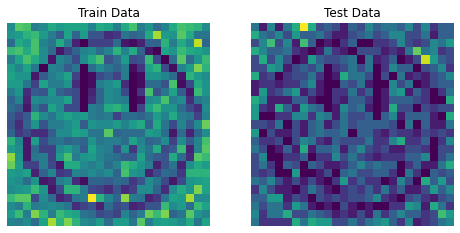

Dataset 2


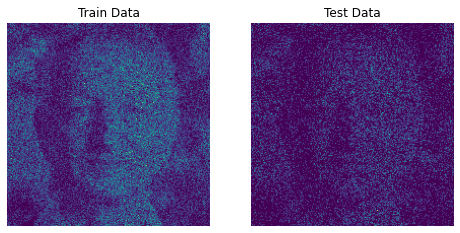

In [3]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

$x'=\sigma(c+(V⊙M^V)h(x)+(A⊙M^A)x)$

In [4]:
from typing import Tuple, List
from tqdm.notebook import tqdm

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [5]:
class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
             
    def set_mask(self, mask):
        # copy mask
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)
        
        # self.weight = self.weight * self.mask
        # return super().forward(input)

In [6]:
class MADE(nn.Module):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 hidden_dims: List[int],
                 n_classes: int = 1,
                 lr: float = 1e-3) -> None:
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_classes = n_classes
        self.hidden_dims = hidden_dims

        layers = [MaskedLinear(n_classes * input_dim, hidden_dims[0])]
        hd = hidden_dims + [n_classes * output_dim]
        for in_features, out_features in zip(hd, hd[1:]):
            layers.extend([
                           nn.ReLU(),
                           MaskedLinear(in_features, out_features)
                           ])
        self.model = nn.Sequential(*layers)
        self.m = self.make_masks()

        self.optim = torch.optim.Adam(self.parameters(), lr=lr)

    def make_masks(self) -> dict:
        masks = []
        m = {}
        m[-1] = np.repeat(np.arange(self.input_dim), self.n_classes)
        for l in range(len(self.hidden_dims)):
            m[l] = np.random.randint(m[l - 1].min(), self.input_dim - 1, size=self.hidden_dims[l])
            masks.append(m[l - 1][:, None] <= m[l][None, :])
        masks.append(m[len(self.hidden_dims) - 1][:, None] < m[-1][None, :])

        layers = [l for l in self.model.modules() if isinstance(l, MaskedLinear)]
        for layer, mask in zip(layers, masks):
            layer.set_mask(mask)
                
        return m

    def forward(self, x) -> torch.tensor:
        batch_size = x.shape[0]
        out = self.model(x)
        out = out.reshape(batch_size, self.output_dim, self.n_classes)
        return out.transpose(2, 1)

    def predict_proba(self, x) -> torch.tensor:
        out = self(x)
        if self.n_classes == 1:
            return torch.sigmoid(out.squeeze())
        return F.softmax(out, dim=-2)

    def __calculate_loss(self, batch, target):
        if self.n_classes == 1:
            return F.binary_cross_entropy(self.predict_proba(batch), target)
        return F.cross_entropy(self(batch), target)
    
    def __step(self, batch, target):
        loss = self.__calculate_loss(batch, target)
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        return loss

    def fit(self,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            device: str = "cpu",
            epochs: int = 100) -> Tuple[List[float], List[float]]:

        train_losses = []
        test_losses = []

        with torch.no_grad():
            for batch, target in test_dataloader:
                batch.to(device)
                loss = self.__calculate_loss(batch.to(device), target.to(device))
                test_losses.append(loss.cpu().numpy())

        for epoch in tqdm(range(epochs), desc="Training"):
            for batch, target in train_dataloader:
                loss = self.__step(batch.to(device), target.to(device))
                train_losses.append(loss.detach().cpu().numpy())

            with torch.no_grad():
                for batch, target in test_dataloader:
                    loss = self.__calculate_loss(batch.to(device), target.to(device))
                    test_losses.append(loss.cpu().numpy())
          
        return train_losses, test_losses

In [7]:
from functools import partial
def collate_fn_a(x, d):
    batch_size = len(x)
    one_hot_x = torch.nn.functional.one_hot(
        x=torch.tensor(x),
        num_classes=d
    ).reshape(batch_size, -1)
    return one_hot_x.float(), torch.tensor(x).long()

In [8]:
from itertools import product
def get_map_probabilities(model, device):
    d = model.n_classes
    map_probabilities = np.zeros((d, d), dtype=np.float64)
    map_coords = np.array(list(product(range(d), range(d))))

    map_coords_dataloader = DataLoader(map_coords,
                                      batch_size=256,
                                      shuffle=False,
                                      collate_fn=partial(collate_fn_a, d=d))

    with torch.no_grad():
        for batch, coords in map_coords_dataloader:
            out = model.predict_proba(batch.to(device))
            for i, (x, y) in enumerate(coords):
                map_probabilities[x, y] = (out[i, x, 0] * out[i, y, 1]).cpu().numpy()
    return map_probabilities

In [9]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """

    lr = 1e-3
    input_dim = output_dim = 2
    hidden_dims = [64, 32, 64]
    n_classes = d
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = MADE(input_dim, output_dim, hidden_dims, n_classes, lr)
    model.to(device)

    epochs = 100
    batch_size = 1024
    shuffle = False

    train_dataloader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  shuffle=shuffle,
                                  collate_fn=partial(collate_fn_a, d=d))
    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 shuffle=shuffle,
                                 collate_fn=partial(collate_fn_a, d=d))

    train_losses, test_losses = model.fit(train_dataloader, test_dataloader, device, epochs)
    
    map_probabilities = get_map_probabilities(model, device)
    return np.array(train_losses), np.array(test_losses), map_probabilities

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Training:   0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 3.1963


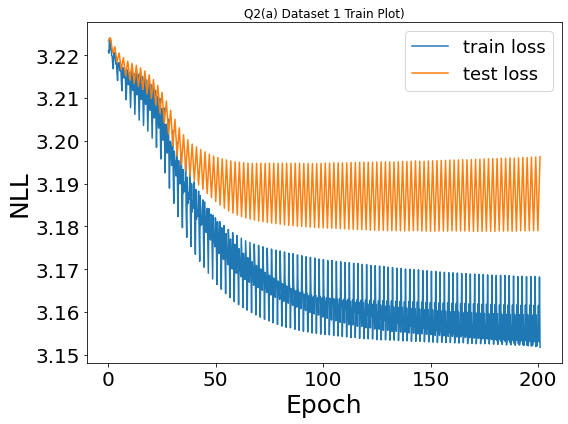

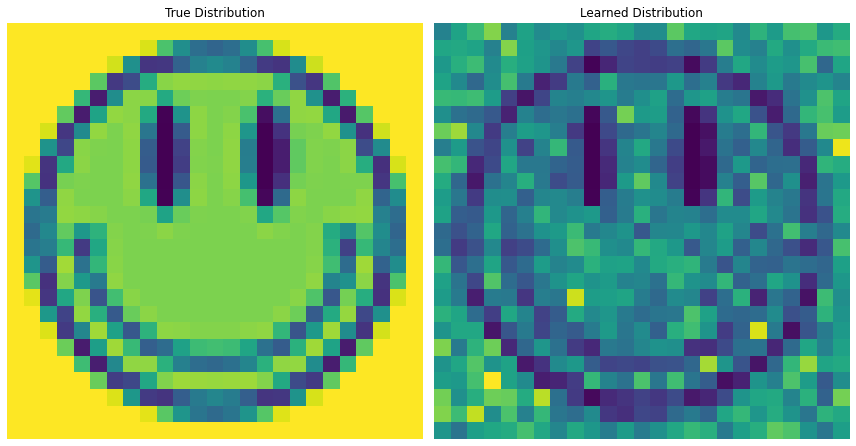

In [10]:
q1_save_results(1, 'a', q1_a)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 5.2856


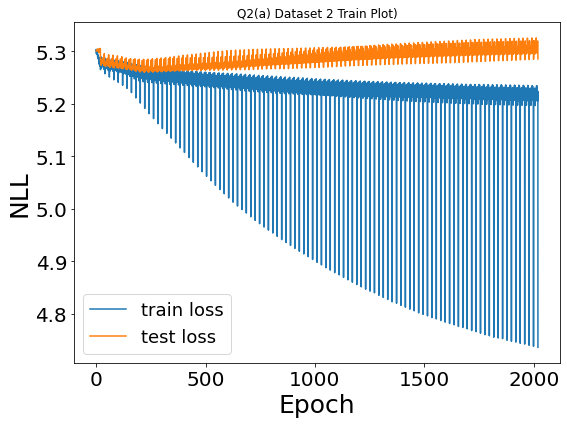

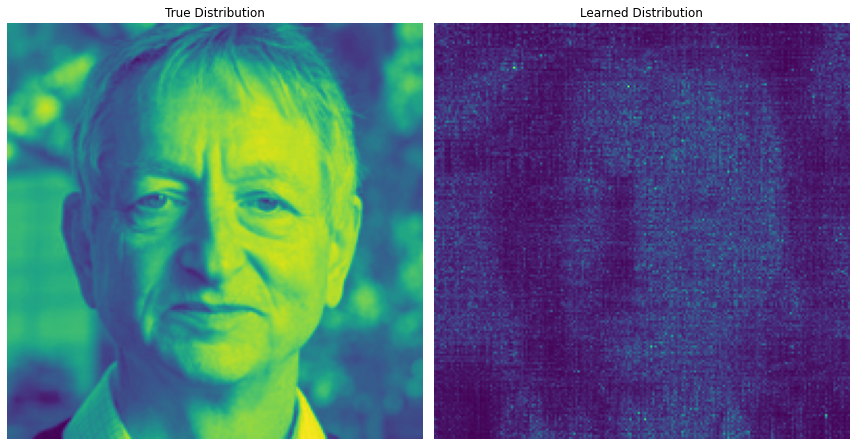

In [11]:
q1_save_results(2, 'a', q1_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

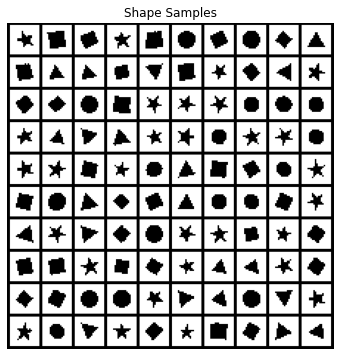

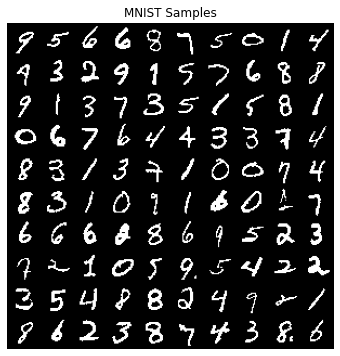

In [12]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [13]:
def collate_fn_b(x):
    batch_size = len(x)
    out = torch.FloatTensor(x).reshape(batch_size, -1)
    return out, out

In [14]:
def get_samplings(model, device, h, w, n=100):
    x = torch.empty(n, h * w, device=device)
    for i in tqdm(range(h * w), desc="Sampling"):
        with torch.no_grad():
            x[:, i] = torch.rand(n, device=device) < model.predict_proba(x)[:, i]
    return x.reshape(n, h, w, 1).cpu().numpy()

In [15]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

    lr = 1e-3
    h, w = image_shape
    input_dim = output_dim = h * w 
    hidden_dims = [64, 32, 64]
    n_classes = 1
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = MADE(input_dim, output_dim, hidden_dims, n_classes, lr)
    model.to(device)

    epochs = 100
    batch_size = 1024
    shuffle = False

    train_dataloader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  shuffle=shuffle,
                                  collate_fn=collate_fn_b)
    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 shuffle=shuffle,
                                 collate_fn=collate_fn_b)

    train_losses, test_losses = model.fit(train_dataloader, test_dataloader, device, epochs)
        
    return np.array(train_losses), np.array(test_losses), get_samplings(model, device, h, w)

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Training:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling:   0%|          | 0/400 [00:00<?, ?it/s]

Final Test Loss: 0.1534


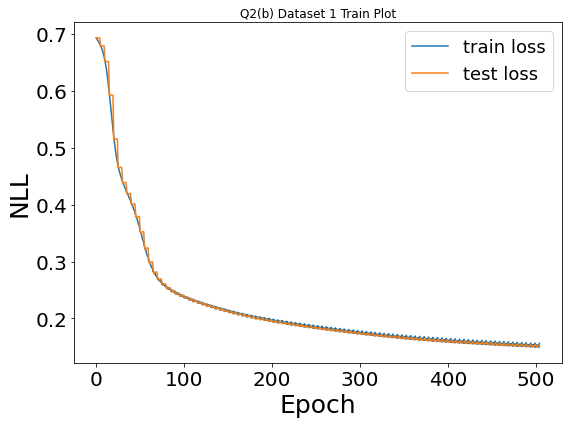

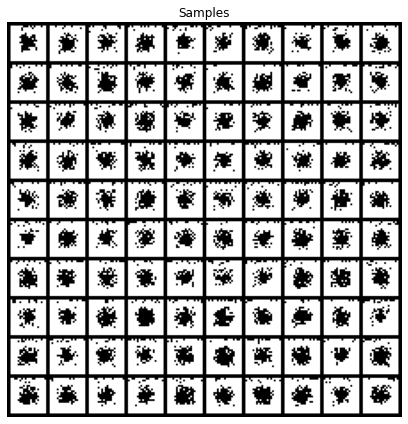

In [16]:
q1_save_results(1, 'b', q1_b)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling:   0%|          | 0/784 [00:00<?, ?it/s]

Final Test Loss: 0.2062


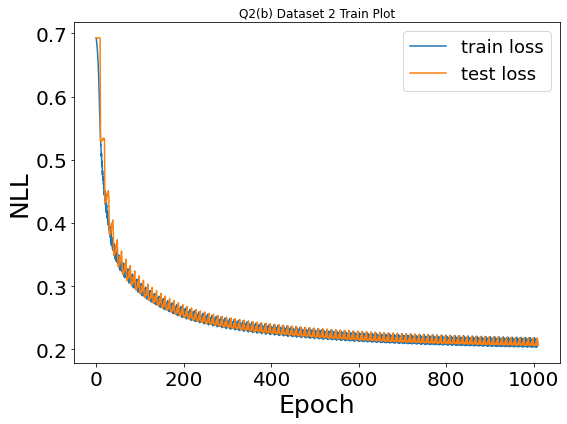

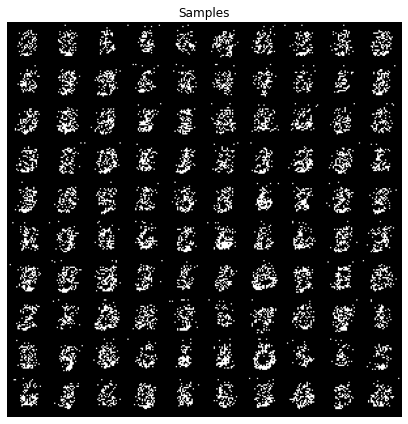

In [18]:
q1_save_results(2, 'b', q1_b)